In [489]:
%pylab inline
import astropy.units as u
import astropy.constants as const

data = np.genfromtxt('Pos_raw_andLlya.txt')

#taking data from the simulation
Pos_Mpc = data[:,0:3]
L_lya = data[:,3] #case B simple Lya (10**42 SFR)
SFR = data[:,4]
Mass_stel = data[:,5]

Populating the interactive namespace from numpy and matplotlib


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['exponential', 'zeros', 'select', 'f', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


$$SFR [M_\odot yr^{-1}] = 1.4 \cdot 10^{-28} L_{\nu} [erg s^{-1} Hz^{-1}]$$

$$L_{\nu} d\nu = L_{\lambda} d\lambda$$

$$L_{\lambda} = L_{\nu} \frac{d\nu}{d\lambda} = L_{\nu} \frac{c}{\lambda^2} = \frac{SFR}{1.4 \cdot 10^{-28}} \frac{c}{\lambda^2}$$

0.07999788224697113 -15.799247376589747
0.7999169230461121 -18.299163363058895
7.92720365524292 -20.789351190146423


Text(0, 0.5, 'M$_1500$')

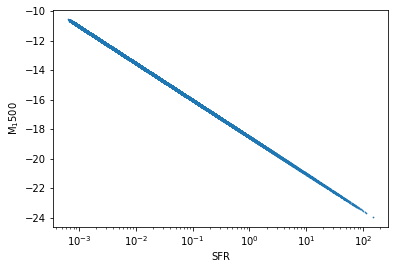

In [490]:
#eliminating halos without SF
ind_nice = np.where(np.logical_and(Mass_stel==0, SFR==0), False, True)
ind_sfr = np.where(SFR>0)

L_lya   = L_lya[ind_sfr]
Pos_Mpc = Pos_Mpc[ind_sfr]
Mass_stel = Mass_stel[ind_sfr]
SFR     = SFR[ind_sfr]

#L_UV starting from Madau Dickinson review
c = const.c.value*10**2 #[cm/s]
pc = const.pc.value*10**2 #[cm]
lambda_ang = 1500 #[A]
lambda_cm = 1500*10**(-8) #[cm]
val_Kenn = 1.4*10**(-28) #for Salpeter IMF
val_Chabr = val_Kenn*0.63 #for Chabrier IMF

#L_nu = SFR/val_Kenn
L_nu = SFR/val_Chabr
L_1500 = L_nu*c/(lambda_ang*lambda_cm)

#L_1500 = SFR*1.4*10**40
#L_nu = L_1500*lambda_ang*lambda_cm/c
#L_nu = np.array(L_nu).astype(np.float)
M_1500 = -2.5*np.log10(L_nu/(4*np.pi*(10*pc)**2))-48.6

print(np.max(SFR[SFR<0.08]), np.min(M_1500[SFR<0.08]))
print(np.max(SFR[SFR<0.8]), np.min(M_1500[SFR<0.8]))
print(np.max(SFR[SFR<8]), np.min(M_1500[SFR<8]))

plt.scatter(SFR, M_1500, s=0.5)
plt.xscale('log')
plt.xlabel('SFR')
plt.ylabel(r'M$_1500$')

## select the function

Text(0.5, 1.0, 'pdf(f|SFR = 1)')

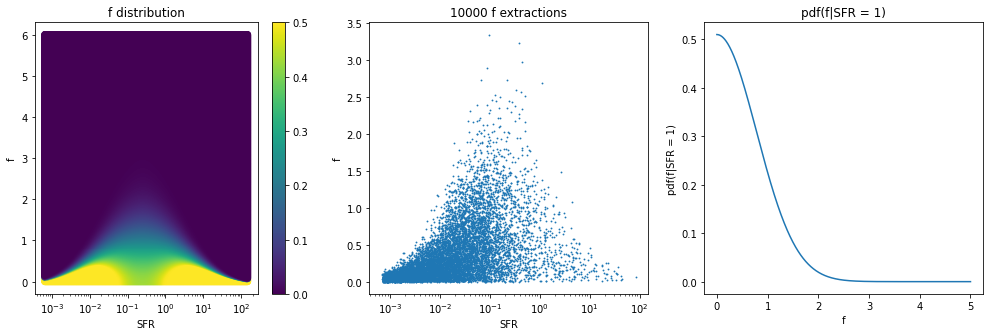

In [491]:
from scipy.stats import norm
from scipy.integrate import quad
from progress.bar import Bar

#0 = only arctan
#1 = arctan + gaus at 0
#2 = gaus with sigma=rarctan
#3 = 2nd degree pol
#4 = gaus with a 2nd degree poly as a sigma
select = 2


SFR_log = np.log10(SFR)
sfr_min = np.min(SFR_log)#10**(-2)
sfr_max = np.max(SFR_log)
delta=sfr_max-sfr_min
f = np.zeros(len(L_lya))

x_linsp = np.linspace(0,5, 1000)
a=4


def gaus2(x,c, mean_0, sigma_0, mean_1, sigma_1):
    fun = c*norm.pdf(x,mean_0,sigma_0)+norm.pdf(x, mean_1, sigma_1)
    return fun

def zero_to_pi(sfr, sfr_min, sfr_max):
    SFR_log = np.log10(sfr)
    return (SFR_log-sfr_min)/(sfr_max-sfr_min)*np.pi/2

def zero_to_one(sfr, sfr_min, sfr_max):
    SFR_log = np.log10(sfr)
    return (SFR_log-sfr_min)/(sfr_max-sfr_min)

def f_dist(sfr,xx, sfr_min,sfr_max, c):
    x_var = zero_to_pi(sfr, sfr_min, sfr_max)  
    
    if select==0:
        mean_1 = np.arctan(np.pi/2-x_var)
        sigma_1 = 0.2*mean_1+0.03
        mean_0 = 0
        sigma_0 = 1000
        fun = gaus2(xx,0,mean_0,sigma_0, mean_1, sigma_1)
        
    if select==1:
        mean_1 = 1.5*np.arctan(np.pi/2-x_var)
        sigma_1 = 0.2*mean_1+0.03
        mean_0 = 0
        sigma_0 = 0.7*mean_1+0.01
        fun = gaus2(xx,c,mean_0,sigma_0, mean_1, sigma_1)
    
    if select==2:
        
        sigma_g = 0.7*norm.pdf(x_var, zero_to_pi(0.25, sfr_min, sfr_max), 0.3)
        fun = norm.pdf(xx,0, sigma_g)
    
    if select==3:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        mean_1 = -x_var**2+1
        sigma_1 = 0.2*mean_1+0.03
        fun = norm.pdf(xx, mean_1, sigma_1)
        
    if select==4:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        mean_1 = 0.
        sigma_1 =(-x_var**2+1)+0.0001
        fun = norm.pdf(xx, mean_1, sigma_1)
        
    return fun

max_ext = 2.3
if select==1:
    max_ext=4
if select==2:
    max_ext=6
if select==4:
    max_ext=5.5

fig,ax = plt.subplots(1,3, figsize=(17,5))
aa = np.logspace(sfr_min,sfr_max, 500)
bb = np.linspace(0,max_ext, 500)
AA, BB = np.meshgrid(aa,bb)
AA = AA.reshape(-1)
BB = BB.reshape(-1)
color = f_dist(AA,BB,sfr_min,sfr_max,a)

max_color = np.nanmax(f_dist(AA,BB,sfr_min,sfr_max,a))
pl =ax[0].scatter(AA,BB, c=color, vmin=0, vmax=0.5)
plt.colorbar(pl, ax = ax[0])
rand_x = np.random.uniform(0,max_ext,len(SFR_log))
rand_y = np.random.uniform(0, max_color+0.0001, len(SFR_log))
ind_change = np.where(rand_y>f_dist(SFR, rand_x, sfr_min, sfr_max,a))

while len(ind_change[0])!=0:
    #print(len(ind_change[0]))
    rand_x[ind_change[0]] = np.random.uniform(0, max_ext, len(ind_change[0]))
    rand_y[ind_change[0]] = np.random.uniform(0, max_color+0.0001, len(ind_change[0]))
    ind_change = np.where(rand_y>f_dist(SFR, rand_x, sfr_min, sfr_max, a))
    
f = rand_x

#plt.scatter(SFR, f)
ax[0].set_xscale('log')
ax[0].set_xlabel('SFR')
ax[0].set_ylabel('f')
ax[0].set_title('f distribution')

rand_indd = np.random.randint(0,len(L_lya), size=10000)
ax[1].scatter(SFR[rand_indd], f[rand_indd], s=0.7)
ax[1].set_xscale('log')
ax[1].set_xlabel('SFR')
ax[1].set_ylabel('f')
ax[1].set_title('10000 f extractions')


ax[2].plot(x_linsp, f_dist(1, x_linsp, sfr_min, sfr_max, a))
ax[2].set_xlabel('f')
ax[2].set_ylabel('pdf(f|SFR = 1)')
ax[2].set_title('pdf(f|SFR = 1)')

Text(2, 1.3, '10 M$_\\odot$ yr$^{-1}$')

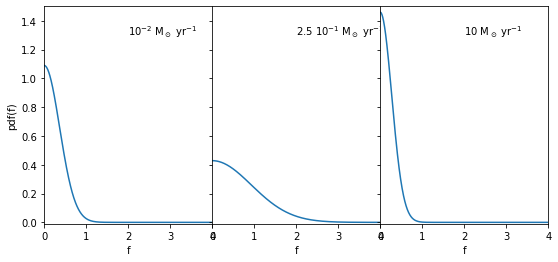

In [492]:
fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(nrows=1, ncols=3, left=0.05, right=0.75,
                      hspace=0., wspace=0.0)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])

ax0.plot(x_linsp, f_dist(0.01, x_linsp, sfr_min, sfr_max, a))

ax0.set_xlabel('f')
ax0.set_ylabel('pdf(f)')
ax0.set_xlim(0,4)
ax0.text(2, 1.3,'10$^{-2}$ M$_\odot$ yr$^{-1}$')
ax0.set_ylim(-0.01,1.5)

ax1.plot(x_linsp, f_dist(2.5e-1, x_linsp, sfr_min, sfr_max, a))
ax1.set_xlabel('f')
ax1.set_xlim(0,4)
ax1.set_ylim(-0.01,1.5)
ax1.text(2, 1.3,'2.5 10$^{-1}$ M$_\odot$ yr$^{-1}$')
ax1.tick_params(labelleft=None)

ax2.plot(x_linsp, f_dist(10, x_linsp, sfr_min, sfr_max, a))
ax2.set_xlabel('f')
ax2.set_xlim(0,4)
ax2.set_ylim(-0.01,1.5)
ax2.tick_params(labelleft=None)
ax2.text(2, 1.3,'10 M$_\odot$ yr$^{-1}$')


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


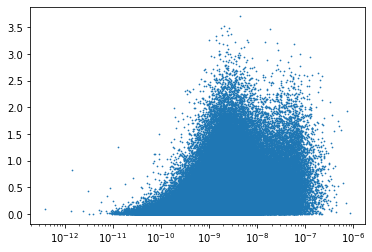

In [493]:
sSFR = SFR/Mass_stel
plt.scatter(sSFR, f, s=0.5)
plt.xscale('log')
#plt.yscale('log')

(array([3.0000e+00, 6.0000e+00, 8.0000e+00, 2.5000e+01, 1.2100e+02,
        3.3900e+02, 1.1520e+03, 3.6200e+03, 1.0661e+04, 2.0565e+04,
        2.1723e+04, 2.3634e+04, 2.7627e+04, 3.1175e+04, 3.1534e+04,
        2.4458e+04, 1.4015e+04, 6.9710e+03, 3.0220e+03, 5.9000e+02]),
 array([32.97947305, 33.48007705, 33.98068105, 34.48128504, 34.98188904,
        35.48249304, 35.98309704, 36.48370103, 36.98430503, 37.48490903,
        37.98551303, 38.48611702, 38.98672102, 39.48732502, 39.98792902,
        40.48853301, 40.98913701, 41.48974101, 41.99034501, 42.490949  ,
        42.991553  ]),
 <BarContainer object of 20 artists>)

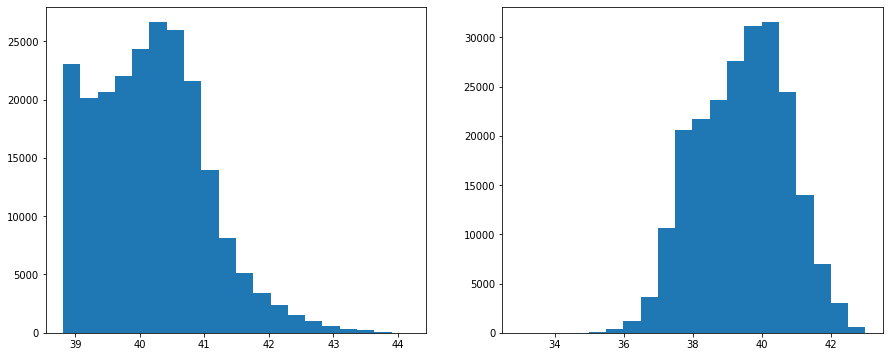

In [494]:
L_lya_obs = L_lya*f

fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].hist(np.log10(L_lya), bins=20)
ax[1].hist(np.log10(L_lya_obs[L_lya_obs!=0]), bins=20)

In [495]:
from lum_func import *
from corr_functions import * 

###LUMINOSITY FUNCTION
av_bin, counts, zeros = Lya_lumfunction(L_lya, 20) #the original case B
av_bin_obs, counts_obs, zeros_obs = Lya_lumfunction(L_lya_obs, 40) #the corrected one

###CORRELATION FUNCTION
N_boot = 1
bins = np.logspace(np.log10(0.1), np.log10(10), 15)
xi = np.zeros((N_boot, len(bins)-1))
xi_obs = np.zeros((N_boot, len(bins)-1))

for i in range(N_boot):
    bins_cen, xi[i], _ = corr_func(500, bins, Pos_Mpc, 0, 100, False)
    bins_cen_ob, xi_obs[i], _ = corr_func(500, bins, Pos_Mpc[L_lya_obs>10**39], 0, 100, False)
    
med_xi = np.median(xi, axis=0)
sigma_xi = (np.percentile(xi, 75, axis=0) - np.percentile(xi, 25, axis=0))*0.7413

med_xi_obs = np.median(xi_obs, axis=0)
sigma_xi_obs = (np.percentile(xi_obs, 75, axis=0) - np.percentile(xi_obs, 25, axis=0))*0.7413

###EW
EW = L_lya_obs/L_1500*(1500/1216)**(-1.5)

###EW fraction to compare with Kusakabe
Kusakabe_bins = np.array([-21.5, -20, -19, -18, -17])
Kusakabe_bins_cen = (Kusakabe_bins[1:]+Kusakabe_bins[:-1])/2

#dividing galaxies in bins of M_1500
ind_bins = [[] for i in range(len(Kusakabe_bins_cen))]
for i in range(len(Kusakabe_bins)-1):
    ind_bins[i] = np.where(np.logical_and(M_1500>=Kusakabe_bins[i], M_1500<Kusakabe_bins[i+1]))
    
#dividing galaxies in bins of EW
EW_thresh = [25,45,65,85]
EW_fraction = np.zeros([len(Kusakabe_bins_cen), len(EW_thresh)])
for j in range(len(Kusakabe_bins_cen)):
    for i in range(len(EW_thresh)):
        EW_fraction[j,i] = len(np.where(EW[ind_bins[j]]>EW_thresh[i])[0])/len(ind_bins[j][0])


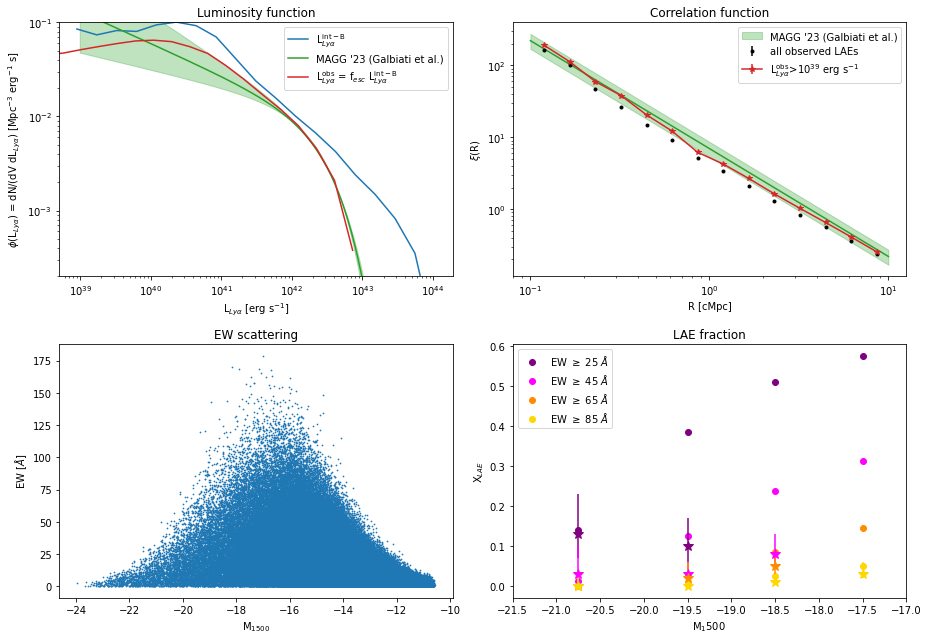

In [496]:
fig, ax = plt.subplots(2,2, figsize=(13,9))
ax=ax.reshape(-1)

##LF
ax[0].plot(av_bin, counts, label=r'L$_{Ly\alpha}^{\mathrm{int-B}}$ ')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Luminosity function')
ax[0].set_ylim(2*10**(-4), 10**(-1))
ax[0].set_xlim()
ax[0].set_xlabel(r'L$_{Ly\alpha}$ [erg s$^{-1}$]')
ax[0].set_ylabel(r'$\phi$(L$_{Ly\alpha}$) = dN/(dV dL$_{Ly\alpha}$) [Mpc$^{-3}$ erg$^{-1}$ s]')

#mackenzie_raw
mack_lf = np.genfromtxt('Mackenzie.txt')
#ax[0].plot(mack_lf[:,0], mack_lf[:,1],label='Mackenzie_raw')

#MAGG LF
def lum_fun(L, phi_star, alpha, L_star):
    return np.log(10)*phi_star*10**((L-L_star)*(alpha +1))*np.exp(-10**(L-L_star))

#from MAGG (the last one is the one I should use, the others are valid for selected samples)
alpha = [-1.164,-1.350,-1.418,-1.339]
L_star = [42.573, 42.558, 42.575, 42.466]
phi_star = [10**(-1.429), 10**(-1.788), 10**(-2.175), 10**(-2.422)]

err_par = [10**(0.121), 0.158, 0.08] #err_phi, err_alpha, err_logL_star

x_logsp = np.logspace(39, 44, 500)

magg = lum_fun(np.log10(x_logsp), phi_star[-1], alpha[-1], L_star[-1])
magg_1s_min = lum_fun(np.log10(x_logsp), phi_star[-1]/err_par[0], alpha[-1]-err_par[1], L_star[-1]+err_par[2])
magg_1s_max = lum_fun(np.log10(x_logsp), phi_star[-1]*err_par[0], alpha[-1]+err_par[1], L_star[-1]-err_par[2])
ax[0].plot((x_logsp), (magg), label="MAGG '23 (Galbiati et al.)", c='tab:green')
ax[0].fill_between((x_logsp), (magg_1s_min), (magg_1s_max), color='tab:green', alpha=0.3)

#with f_esc
ax[0].plot(av_bin_obs, counts_obs, c='tab:red', label=r'L$_{Ly\alpha}^{\mathrm{obs}}$ = f$_{esc}$ L$_{Ly\alpha}^{\mathrm{int-B}}$') 

ax[0].legend()

##CORRELATION
ax[1].errorbar(bins_cen, med_xi, sigma_xi, fmt='.k', label=r'all observed LAEs')
ax[1].errorbar(bins_cen_ob, med_xi_obs, sigma_xi_obs, color='tab:red', marker='*', label=r'L$_{Ly\alpha}^{\mathrm{obs}}$>10$^{39}$ erg s$^{-1}$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('R [cMpc]')
ax[1].set_ylabel(r'$\xi$(R)')
ax[1].set_title('Correlation function')
x_log = np.logspace(-1,1,100)
#ax[1].plot(x_log, (x_log/2.95)**(-1.47), label='from LF calibration')
ax[1].plot(x_log, (x_log*0.6777/2.47)**(-1.5), color='tab:green')
ax[1].fill_between(x_log, (x_log*0.6777/2.07)**(-1.5), (x_log*0.6777/2.85)**(-1.5), color='tab:green', 
                   alpha=0.3, label="MAGG '23 (Galbiati et al.)")
ax[1].legend()

##EW scatter
ax[2].scatter(M_1500, EW, s=0.5)
ax[2].set_xlabel(r'M$_{1500}$')
ax[2].set_ylabel(r'EW [$\AA$]')
ax[2].set_title('EW scattering')
#ax[2].set_xscale('log')
#ax[2].set_xlim(-10,-24)
#ax[2].set_ylim(0,90)

##LAE fraction
Kusak_res_25 = [0.13, 0.10]
Kusak_res_25_err = [[0.06,0.04], [0.1, 0.07]]
Kusak_res_45 = [0.03, 0.03, 0.08]
Kusak_res_45_err = [[0.02, 0.02, 0.03],[0.07, 0.03, 0.05]]
Kusak_res_65 = [0.00, 0.02, 0.05]
Kusak_res_65_err = [[0.00, 0.01, 0.02],[0.03,0.04, 0.04]]
Kusak_res_85 = [0.00, 0.00, 0.01, 0.03]
Kusak_res_85_err = [[0.00,0.00,0.00,0.01], [0.03, 0.02, 0.02, 0.03]]

Kusak_res = [Kusak_res_25, Kusak_res_45, Kusak_res_65, Kusak_res_85]
Kusak_err = [Kusak_res_25_err, Kusak_res_45_err, Kusak_res_65_err, Kusak_res_85_err]

color_list = ['purple', 'magenta', 'darkorange', 'gold']
for i in range(4):
    ax[3].errorbar(Kusakabe_bins_cen[:len(Kusak_res[i])], Kusak_res[i], yerr=Kusak_err[i], marker='*', markersize=10, ls='', color=color_list[i])
    ax[3].scatter(Kusakabe_bins_cen, EW_fraction[:,i], label=r'EW $\geq$ %i $\AA$' %EW_thresh[i], color=color_list[i])
ax[3].set_xlim(-21.5, -17)
ax[3].set_xlabel(r'M$_1500$')
ax[3].set_ylabel(r'X$_{LAE}$')
ax[3].set_title('LAE fraction')
ax[3].legend()
#ax[3].set_ylim(0,0.3)
fig.tight_layout()

43.58535016463154


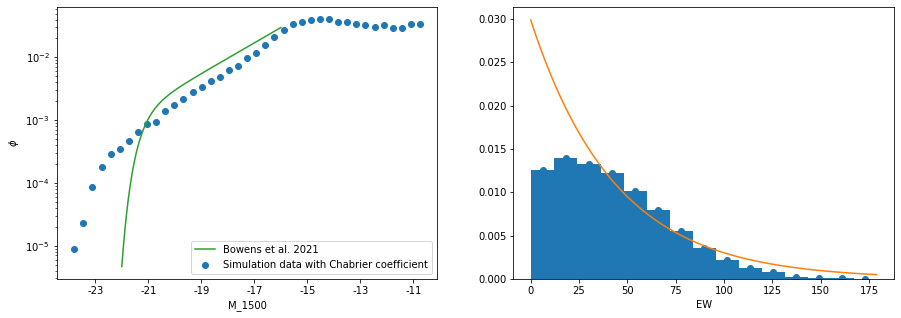

In [497]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

av_bin_obs1500, counts_obs1500, zeros_obs1500 = Lya_lumfunction(10**(M_1500), 40)
ax[0].scatter(av_bin_obs1500, counts_obs1500, label='Simulation data with Chabrier coefficient')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('M_1500')
ax[0].set_ylabel(r'$\phi$')

#From Bowens 2021 UV lum function at z about 3
def schechter_fun(M, phi_star, alpha, M_star):
    return phi_star*np.log(10)/2.5*10**((M_star-M)*(alpha +1)/2.5)*np.exp(-10**(M_star-M)/2.5)
Bow_par = [2.1*10**(-3), -1.61, -20.87]
mag_space = np.linspace(-22, -16, 300)
ax[0].plot(10**mag_space, schechter_fun(mag_space, Bow_par[0], Bow_par[1], Bow_par[2]), color='tab:green', label='Bowens et al. 2021')
ax[0].legend()
ax[0].set(xticks= [10**(-23), 10**(-21), 10**(-19), 10**(-17), 10**(-15), 10**(-13), 10**(-11)],
                     xticklabels= ['-23', '-21', '-19', '-17', '-15', '-13', '-11'])
    
counts_ew, bins_ew = np.histogram(EW[L_lya_obs>3*10**41], bins=15, density=True)
bins_cen_ew = (bins_ew[1:]+bins_ew[:-1])/2
ax[1].hist(EW[L_lya_obs>3*10**41], bins=15, density=True)
ax[1].scatter(bins_cen_ew, counts_ew)
def exponential(x, w0, N):
    return N*np.exp(-x/w0)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(exponential, bins_cen_ew[2:], counts_ew[2:], p0=[95, 40000]) 
ew_lin = np.linspace(np.min(EW), np.max(EW), 100)
ax[1].plot(ew_lin, exponential(ew_lin, popt[0], popt[1]))
ax[1].set_xlabel('EW')
print(popt[0])

Text(0, 0.5, 'log$_{10}$(Z$_\\star$/Z$_\\odot$)')

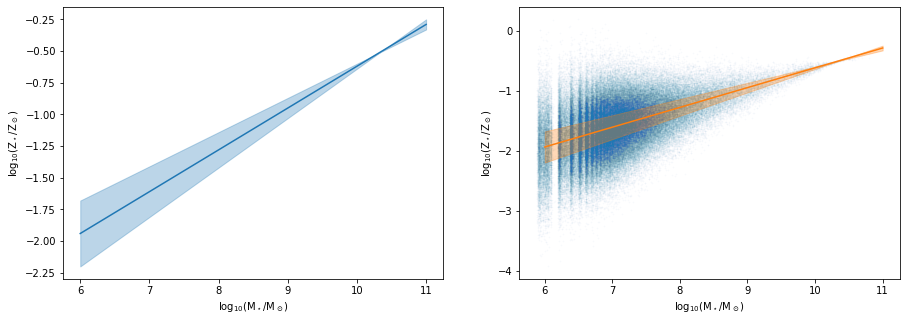

In [498]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
mass_logs = np.linspace(6,11)
ax[0].plot(mass_logs, 0.33*((mass_logs)-10)-0.62)
ax[0].fill_between(mass_logs, 0.27*((mass_logs)-10)-0.60, 0.39*((mass_logs)-10)-0.64, color='tab:blue', alpha=0.3)
ax[0].set_xlabel(r'log$_{10}$(M$_\star$/M$_\odot$)')
ax[0].set_ylabel(r'log$_{10}$(Z$_\star$/Z$_\odot$)')

means_z = 0.33*(np.log10(Mass_stel[Mass_stel>0])-10)-0.62
sigma_z = np.abs((0.27*(np.log10(Mass_stel[Mass_stel>0])-10)-0.60) - (0.39*(np.log10(Mass_stel[Mass_stel>0])-10)-0.64))
random_met = np.random.normal(loc=means_z, scale=sigma_z)

ax[1].scatter(np.log10(Mass_stel[Mass_stel>0]), random_met, alpha=0.02, s=0.7)
ax[1].plot(mass_logs, 0.33*((mass_logs)-10)-0.62,c='tab:orange')
ax[1].fill_between(mass_logs, 0.27*((mass_logs)-10)-0.60, 0.39*((mass_logs)-10)-0.64, color='tab:orange', alpha=0.3)
ax[1].set_xlabel(r'log$_{10}$(M$_\star$/M$_\odot$)')
ax[1].set_ylabel(r'log$_{10}$(Z$_\star$/Z$_\odot$)')

(1e-05, 0.1)

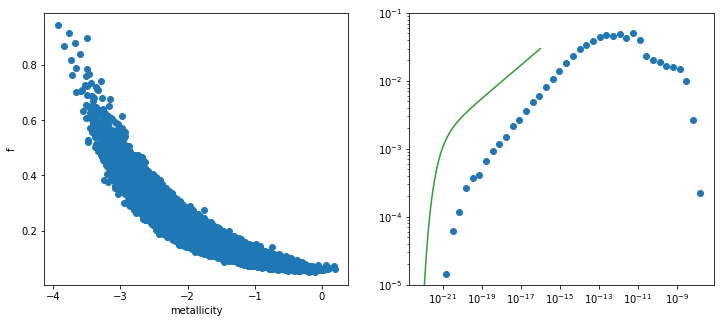

In [609]:
#plt.scatter(random_met, M_1500[Mass_stel!=0], s=0.5)

mean_tau = -0.5*(np.abs(random_met))**(5/4)+2.8
sigma_tau = 1*mean_tau
tau = np.random.normal(mean_tau, sigma_tau)
fig,ax =plt.subplots(1,2,figsize=(12,5))

f_uv = np.ones(len(Mass_stel))
j=0
for i in range(len(Mass_stel)):
    if Mass_stel[i]>0:
        f_uv[i] = np.exp(-tau[j])
        j +=1
        
ax[0].scatter(random_met, f_uv[f_uv!=1])
ax[0].set_xlabel('metallicity')
ax[0].set_ylabel('f')
L_uv_corr = L_1500 * f_uv

M_uv_corr = -2.5*np.log10(L_uv_corr*(lambda_ang*lambda_cm)/(4*c*np.pi*(10*pc)**2))-48.6
binc1500, counts_c, zeros_c = Lya_lumfunction(10**(M_uv_corr), 40)
ax[1].plot(10**mag_space, schechter_fun(mag_space, Bow_par[0], Bow_par[1], Bow_par[2]), color='tab:green', label='Bowens et al. 2021')

plt.scatter(binc1500, counts_c)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**(-5), 10**(-1))

Text(0, 0.5, 'L_lya')

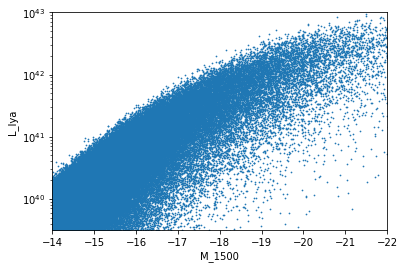

In [600]:
plt.scatter(M_1500, L_lya_obs, s=0.5)
plt.yscale('log')
plt.xlim(-14,-22)
plt.ylim(10**(39.5), 1e43)
plt.xlabel('M_1500')
plt.ylabel('L_lya')

(1000000, 1000000000000)

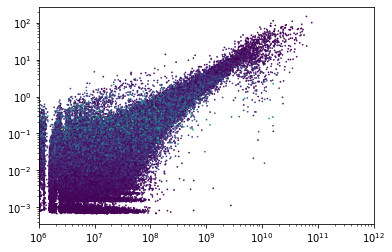

In [326]:
plt.scatter(Mass_stel,SFR, s=0.5, c=f)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**6, 10**12)

## Byrhol

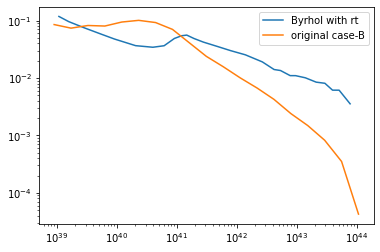

In [357]:
data_rt = np.genfromtxt('byrhol_rt.txt')
plt.plot(10**data_rt[:,0], 10**data_rt[:,1], label='Byrhol with rt')
plt.plot(av_bin, counts, label='original case-B')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [62]:
generic_name = '/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/'
specific_name = 'snapshot_012_z003p017/snap_012_z003p017.'

import h5py as h5
import read_eagle
h5py.enable_ipython_completer()

snapfile = generic_name+specific_name+'0.hdf5'

with h5.File(snapfile,'r') as f:
    num_files = f['Header'].attrs['NumFilesPerSnapshot']
        

metallicity = []
for i in range(num_files):
    myfile = read_eagle.EagleSnapshot(generic_name + specific_name+'%d.hdf5' %(i))
    myfile.select_region(0.1,0.2,0.1,0.2,0.1,0.2)
    metallicity.append(np.array(myfile.read_dataset(0, "Metallicity")))
#NumFilesPerSnapshot = myfile'/Header'.attrs['NumFilesPerSnapshot']

'''
NumFilesPerSnapshot = myfile['Header'].attrs['NumFilesPerSnapshot']
#myfile.close()
print(NumFilesPerSnapshot)

myfile1 = generic_name+specific_name[0]+'0.hdf5'
myfile = h5py.File(myfile1, 'r')

snap = read_eagle.EagleSnapshot("/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017/snap_012_z003p017.")

delta_c = 0.2

num_halos=2
#np.random.seed(99)
#halos_ind = np.random.randint(0, len(Pos[0]), num_halos)
halos_ind=[0,72257]

pos_part = []
temp = []
density = []
metallicity = []

for i in halos_ind:
    snap = read_eagle.EagleSnapshot("/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017/snap_012_z003p017.0.hdf5")
    delta_c = 0.3
    snap.select_region(Pos[0][i,0]-delta_c, Pos[0][i,0]+delta_c, Pos[0][i,1]-delta_c, Pos[0][i,1]+delta_c, Pos[0][i,2]-delta_c, Pos[0][i,2]+delta_c)
    pos_part.append(snap.read_dataset(0, "Coordinates"))#0 = particle type
    temp.append(snap.read_dataset(0, "Temperature"))
    density.append(np.array(snap.read_dataset(0, "Density")))
    metallicity.append(np.array(snap.read_dataset(0, "Metallicity")))
    #ids.append(np.array(snap.read_dataset(0, "ParticleIDs")))
    del snap'''

'\nNumFilesPerSnapshot = myfile[\'Header\'].attrs[\'NumFilesPerSnapshot\']\n#myfile.close()\nprint(NumFilesPerSnapshot)\n\nmyfile1 = generic_name+specific_name[0]+\'0.hdf5\'\nmyfile = h5py.File(myfile1, \'r\')\n\nsnap = read_eagle.EagleSnapshot("/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017/snap_012_z003p017.")\n\ndelta_c = 0.2\n\nnum_halos=2\n#np.random.seed(99)\n#halos_ind = np.random.randint(0, len(Pos[0]), num_halos)\nhalos_ind=[0,72257]\n\npos_part = []\ntemp = []\ndensity = []\nmetallicity = []\n\nfor i in halos_ind:\n    snap = read_eagle.EagleSnapshot("/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017/snap_012_z003p017.0.hdf5")\n    delta_c = 0.3\n    snap.select_region(Pos[0][i,0]-delta_c, Pos[0][i,0]+delta_c, Pos[0][i,1]-delta_c, Pos[0][i,1]+delta_c, Pos[0][i,2]-delta_c, Pos[0][i,2]+delta_c)\n    pos_part.append(snap.read_dataset(0, "Coordinates"))#0 = particle type\n    temp.append(snap.read_